In [6]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import os
from util import get_data, plot_data
import indicators as idc
import csv    

In [7]:
symbol = 'JPM'
sd=dt.datetime(2008,1,1)
ed=dt.datetime(2009, 12, 31)
sv = 100000

In [84]:
def grid_search(df_prices):
    stats = pd.Series(np.zeros(4), index=['cr', 'adr', 'sddr', 'sr'], name='0')
    range_bbdays = [20] #[5, 10, 20, 30, 50]
    range_ndays_momentum = [20] # [5, 10, 20, 30, 50]
    range_ndays_std = [5, 10, 20]
    range_tresh_bband = [0.8,0.9,1] #[0.5, 0.6, 0.7, 0.8, 0.9, 1]
    range_tresh_momentum = [0.2, 0.3, 0.4]
    range_tresh_std_low = [0.0,  1, 2,  3, 5]
    range_tresh_std_high = [0.0,  1, 2,  3, 5]
    for bb_days in range_bbdays:
        print('ya')
        for mm_days in range_ndays_momentum:
            for std_days in range_ndays_std:
                for bb_tr in range_tresh_bband:
                    for mm_tr in range_tresh_momentum:
                        for std_tr_low in range_tresh_std_low:
                            for std_tr_high in range_tresh_std_high:
                                name = str(bb_days)+'/'+str(mm_days)+'/'+str(std_days)+'/'+str(bb_tr)+'/'+str(mm_tr)+'/'+str(std_tr_low)+'/'+str(std_tr_high)
                                df_trades, bband = testPolicyMixed(
                                    bb_days, mm_days, std_days, bb_tr, mm_tr, std_tr_low, std_tr_high,
                                    symbol='JPM', sd=dt.datetime(2008, 1, 1, 0, 0),
                                    ed=dt.datetime(2009, 12, 31, 0, 0), sv=100000
                                )
                                portfolio = normalize_dataframe(
                                    get_portfolio_value(df_prices, df_trades,'JPM', name)
                                )
                                stats_porfolio = compute_portfolio_stats(portfolio.values, name=name)
                                stats = pd.concat([stats, stats_porfolio], axis = 1)
                            
                
    return stats

def compute_portfolio_stats(port_val, rfr = 0.0, sf = 252.0, name = 'stats'):
    # daily returns on portfolio value
    daily_rets = (port_val[1:] / port_val[0:-1]) - 1
    daily_rets = daily_rets[1:]
    # compute stats
    cr = (port_val[-1] / port_val[0]) - 1
    adr = daily_rets.mean()
    sddr = daily_rets.std()
    sr = np.sqrt(sf) * ((adr - rfr) / sddr)
    
    return pd.Series(data= [cr, adr, sddr, sr], index=['cr', 'adr', 'sddr', 'sr'], name=name)


def normalize_dataframe(dataframe):
    return dataframe/dataframe.iloc[0]

def get_benchmark(df_prices, sv = 100000):
    df_trades = pd.DataFrame(data = np.zeros((len(df_prices),2)), 
                             index = df_prices.index, columns=['benchmark', 'cash'])
    # BUY 1000 JPM and hold
    df_trades.iloc[0] = [1000, 100000 - 1000 * df_prices.iloc[0]]
    df_holdings = df_trades.cumsum(axis = 0)
    df_holdings.benchmark *= df_prices
    df_portval = df_holdings.sum(axis = 1)
    df_portval = pd.DataFrame(data = df_portval, index = df_prices.index, columns=['benchmark'])
    return df_portval

def get_portfolio_value(df_prices, df_trades, symbol, name = 'rule-based portfolio'):
    best_df = pd.concat([df_prices, df_trades], axis = 1)
    best_df['cash'] = - best_df[symbol] * best_df.trades
    best_df['cash'] = best_df['cash'].cumsum(axis = 0) + sv
    best_df['holding'] = best_df.trades.cumsum(axis = 0) * best_df[symbol]
    port_val = pd.DataFrame(best_df.holding + best_df.cash, columns=[name])
    return port_val

def crossed_from_above(crossed, crosser, t):
    return (crosser[t-1] > crossed[t]) & (crosser[t] <= crossed[t])

def crossed_from_below(crossed, crosser, t):
    return (crosser[t-1] < crossed[t]) & (crosser[t] >= crossed[t])

def get_portfolios_dataframe(policy, df_prices, range_ndays):
    df_trades, bband = policy(range_ndays[0])
    portfolios = normalize_dataframe(get_portfolio_value(df_prices, df_trades, 'JPM', str(range_ndays[0])))
    for n_days in range_ndays[1:]:
        df_trades, bband = policy(n_days)
        portfolio = normalize_dataframe(get_portfolio_value(df_prices, df_trades, 'JPM', str(n_days)))
        portfolios = pd.concat([portfolios, portfolio], axis = 1)
    
    return portfolios

def get_portfolios_dataframe_tresh(policy, df_prices, range_tresh):
    df_trades, bband = policy(20, range_tresh[0])
    portfolios = normalize_dataframe(get_portfolio_value(df_prices, df_trades, 'JPM', str(range_tresh[0])))
    for n_tresh in range_tresh[1:]:
        df_trades, bband = policy(20, n_tresh)
        portfolio = normalize_dataframe(get_portfolio_value(df_prices, df_trades, 'JPM', str(n_tresh)))
        portfolios = pd.concat([portfolios, portfolio], axis = 1)
    
    return portfolios

def testPolicyBBand(n_days, symbol = "JPM", sd=dt.datetime(2008,1,1), ed=dt.datetime(2009, 12, 31), sv = 100000):
    df_prices_all = get_data([symbol], pd.date_range(sd, ed))
    df_prices = df_prices_all[symbol]
    df_trades = pd.DataFrame(data = np.zeros(len(df_prices)), index = df_prices.index, columns=['trades'])
    
    bband = idc.get_bbands(pd.DataFrame(df_prices, index = df_prices.index, columns = [symbol]),  n_days)
    tresh = 0.9
    # use bolinger band @try to vectorize ? 
    for t in range(1, len(df_prices)):
        # buy signal 
        if (bband[t-1] <= - tresh) & (bband[t] > -  tresh):
            df_trades.iloc[t] = 1000
        # sell signal
        if (bband[t-1] >= tresh) & (bband[t] < tresh):
            df_trades.iloc[t] = -1000
    return df_trades, bband

def testPolicyBBand_rmean(n_rmean, symbol = "JPM", sd=dt.datetime(2008,1,1), ed=dt.datetime(2009, 12, 31), sv = 100000):
    df_prices_all = get_data([symbol], pd.date_range(sd, ed))
    df_prices = df_prices_all[symbol]
    df_trades = pd.DataFrame(data = np.zeros(len(df_prices)), index = df_prices.index, columns=['trades'])
    
    n_days = 30
    bband = idc.get_bbands(pd.DataFrame(df_prices, index = df_prices.index, columns = [symbol]),  n_days)
    rmean_bband = idc.get_rolling_mean(bband, n_rmean)
    # use bolinger band @try to vectorize ? 
    for t in range(1, len(df_prices)):
        # buy signal 
        if crossed_from_above(rmean_bband, bband, t):
            df_trades.iloc[t] = 1000
        # sell signal
        if crossed_from_below(rmean_bband, bband, t):
            df_trades.iloc[t] = -1000
    return df_trades, bband

def testPolicyMixed(n_days_bb=20, n_days_mtum=20, n_days_std=20,
                    tresh_bb=1, tresh_mmtum = 0.2, tresh_std_low=1, tresh_std_high=1,
                    symbol = "JPM", sd=dt.datetime(2008,1,1),
                    ed=dt.datetime(2009, 12, 31), sv = 100000):
    df_prices_all = get_data([symbol], pd.date_range(sd, ed))
    df_prices = df_prices_all[symbol]
    df_trades = pd.DataFrame(data = np.zeros(len(df_prices)), index = df_prices.index, columns=['trades'])
    
    rstd = idc.get_rolling_stdev(pd.DataFrame(df_prices, index = df_prices.index, columns = [symbol]),  n_days_std)
    bband = idc.get_bbands(pd.DataFrame(df_prices, index = df_prices.index, columns = [symbol]),  n_days_bb)
    momentum = idc.get_momentum(pd.DataFrame(df_prices, index = df_prices.index, columns = [symbol]),  n_days_mtum)
    abs_momentum = momentum.abs()
    
    #use volatility as a filter:
        # if std to low, time to buy, std will increase soon,
        # if std to high, means the growth was strong but will back to the mean
    # use momentum to confirm sell & buy signal:
        # confirmed if small enough momentum 
        # (changes in prices is slowing - time to take action)
    for t in range(1, len(df_prices)):
        #if rstd[t] >= tresh_std:
            # buy signal 
        if (bband[t-1] <= -tresh_bb) & (bband[t] > -tresh_bb):
            if (abs_momentum[t] <= tresh_mmtum):
                if rstd[t] <= tresh_std_low:
                    df_trades.iloc[t] = 1000
        # sell signal
        if (bband[t-1] >= tresh_bb) & (bband[t] < tresh_bb):
            if (abs_momentum[t] <= tresh_mmtum):
                if rstd[t] >= tresh_std_high:
                    df_trades.iloc[t] = -1000
    return df_trades, rstd


def testPolicyMomentum(n_days, symbol = "JPM", sd=dt.datetime(2008,1,1), 
                             ed=dt.datetime(2009, 12, 31), sv = 100000, n_rmean = 20):
    df_prices_all = get_data([symbol], pd.date_range(sd, ed))
    df_prices = df_prices_all[symbol]
    df_trades = pd.DataFrame(data = np.zeros(len(df_prices)), index = df_prices.index, columns=['trades'])
    
    momentum = idc.get_momentum(pd.DataFrame(df_prices, index = df_prices.index, columns = [symbol]),  n_days)
    ref_0_line = np.zeros(len(momentum)) 
    # when momentum cross 0 from above : speed is decreasing 
    # - > prices will stop increasing : SELL
    # when momentum cross 0 from below : speed is decreasing 
    # -> prices will stop decreasing : BUY
    for t in range(1, len(df_prices)):
        # buy signal 
        if crossed_from_below(ref_0_line, momentum, t):
            df_trades.iloc[t] = 1000
        # sell signal
        if crossed_from_above(ref_0_line, momentum, t):
            df_trades.iloc[t] = -1000
    return df_trades, momentum

def testPolicyMomentum_rmean(symbol = "JPM", sd=dt.datetime(2008,1,1), 
                             ed=dt.datetime(2009, 12, 31), sv = 100000, n_rmean = 20):
    df_prices_all = get_data([symbol], pd.date_range(sd, ed))
    df_prices = df_prices_all[symbol]
    df_trades = pd.DataFrame(data = np.zeros(len(df_prices)), index = df_prices.index, columns=['trades'])
    
    n_days = 10
    #n_rmean = 10
    momentum = idc.get_momentum(pd.DataFrame(df_prices, index = df_prices.index, columns = [symbol]),  n_days)
    rmean_momentum = idc.get_rolling_mean(momentum, n_rmean)
    ref_0_line = np.zeros(len(momentum)) 
    # when rmean of momentum cross 0 from above : speed is decreasing 
    # - > prices will stop increasing : SELL
    # when rmean of momentum cross 0 from below : speed is decreasing 
    # -> prices will stop decreasing : BUY
    for t in range(1, len(df_prices)):
        # buy signal 
        if crossed_from_below(ref_0_line, rmean_momentum, t):
            df_trades.iloc[t] = 1000
        # sell signal
        if crossed_from_above(ref_0_line, rmean_momentum, t):
            df_trades.iloc[t] = -1000
    return df_trades, momentum

In [21]:
df_prices_all = get_data([symbol], pd.date_range(sd, ed))
df_prices = df_prices_all[symbol]
benchmark = normalize_dataframe(get_benchmark(df_prices))

### BBand based strategy

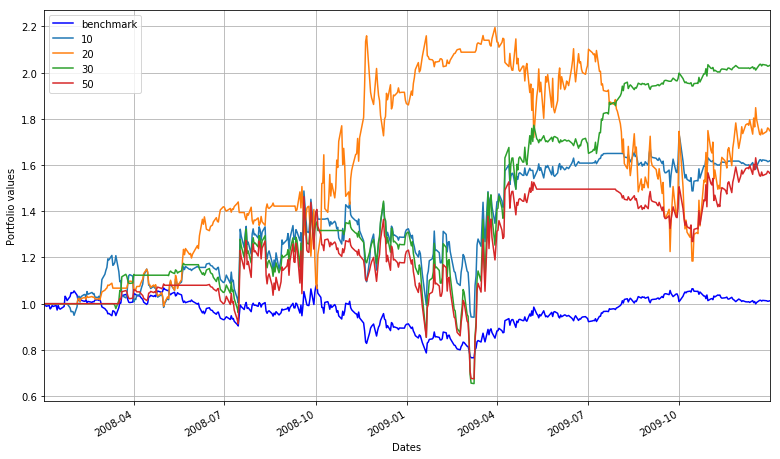

In [22]:
# compare n_days
range_ndays = [10, 20, 30, 50]
bband_portolios_dataframe = get_portfolios_dataframe(testPolicyBBand, df_prices, range_ndays)
idc.plot_compare_portfolios(bband_portolios_dataframe, benchmark)

In [23]:
port_stats_20 = compute_portfolio_stats(bband_portolios_dataframe['20'].values, name='bband 20')
port_stats_30 = compute_portfolio_stats(bband_portolios_dataframe['30'].values, name='bband 30')
#port_stats_50.head(n=4)
pd.concat([port_stats_20, port_stats_30], axis = 1)

,bband 20,bband 30
cr,0.748500,1.030800
adr,0.001876,0.002298
sddr,0.039258,0.043180
sr,0.758740,0.844988


We choose 30 days for the bband. Higher cumulative return and sharpe ratios.

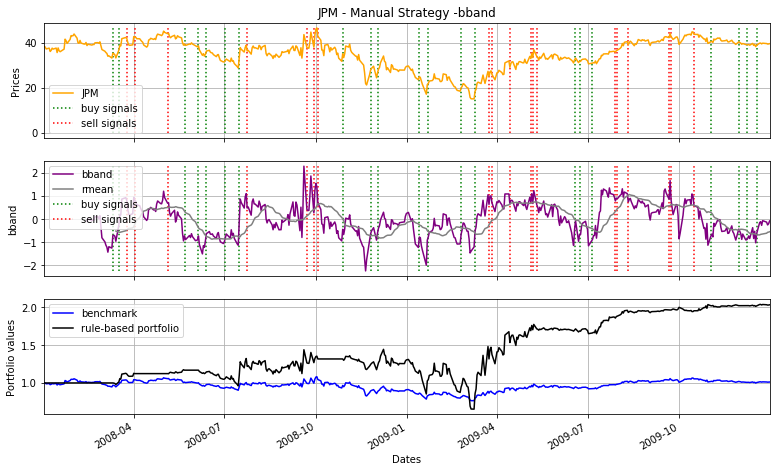

In [24]:
# bband strategy
n_days_bband = 30
df_trades_bband, bband = testPolicyBBand(n_days_bband, 'JPM', dt.datetime(2008,1,1), dt.datetime(2009, 12, 31))
df_buy_signals_bband = df_trades_bband[df_trades_bband.values == 1000]
df_sell_signals_bband = df_trades_bband[df_trades_bband.values == -1000]
df_portval_bband = normalize_dataframe(get_portfolio_value(df_prices, df_trades_bband, symbol))

idc.plot_strategy(df_prices, df_portval_bband, benchmark, bband, 'bband', df_buy_signals_bband, df_sell_signals_bband)

### RMEAN BBAND based strategy

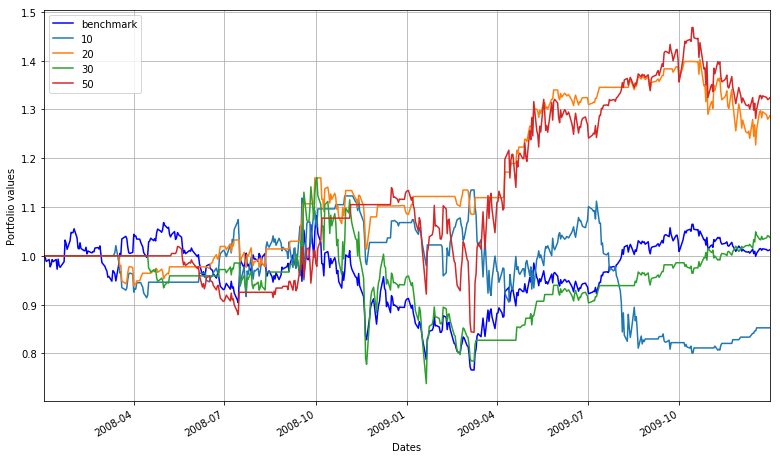

In [32]:
# compare n_rmean
bband_rmean_portolios_dataframe = get_portfolios_dataframe(testPolicyBBand_rmean, df_prices, range_ndays)
idc.plot_compare_portfolios(bband_rmean_portolios_dataframe, benchmark)

In [26]:
pd.concat([
    compute_portfolio_stats(bband_rmean_portolios_dataframe['20'].values, name ='20'), 
    compute_portfolio_stats(bband_rmean_portolios_dataframe['50'].values, name ='50')], axis = 1)

,20,50
cr,0.286800,0.323500
adr,0.000566,0.000749
sddr,0.011374,0.019719
sr,0.789944,0.603322


For this strategy we would use n_days = 20 for bband and n_rmean = 20 for rmean of bband

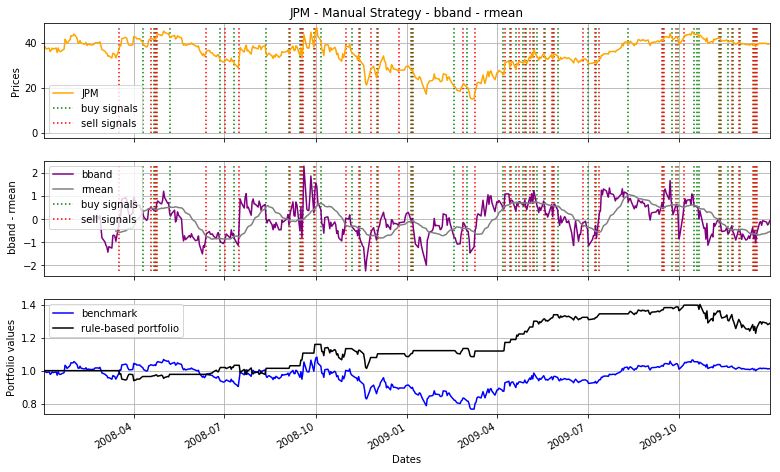

In [27]:
#rmean bband strategy
df_trades_bband_rmean, bband = testPolicyBBand_rmean(20,'JPM', dt.datetime(2008,1,1), dt.datetime(2009, 12, 31))
df_buy_signals_bband_rmean = df_trades_bband_rmean[df_trades_bband_rmean.values == 1000]
df_sell_signals_bband_rmean = df_trades_bband_rmean[df_trades_bband_rmean.values == -1000]
df_portval_bband_rmean = normalize_dataframe(get_portfolio_value(df_prices, df_trades_bband_rmean, symbol))

idc.plot_strategy(df_prices, df_portval_bband_rmean, benchmark, bband, ' bband - rmean', df_buy_signals_bband_rmean, df_sell_signals_bband_rmean)

### MIX strategy - bband & momentum

In [ ]:
# takes time !!! #
portfolios = grid_search(df_prices)

ya


/Users/alexisdurocher/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:41: RuntimeWarning: invalid value encountered in double_scalars


In [ ]:
print('params ', portfolios.loc['sr'].argmax())
print('sharpe ratios', portfolios[portfolios.loc['sr'].argmax()])
portfolios['20/20/5/0.8/0.2/3/0.0'].head()

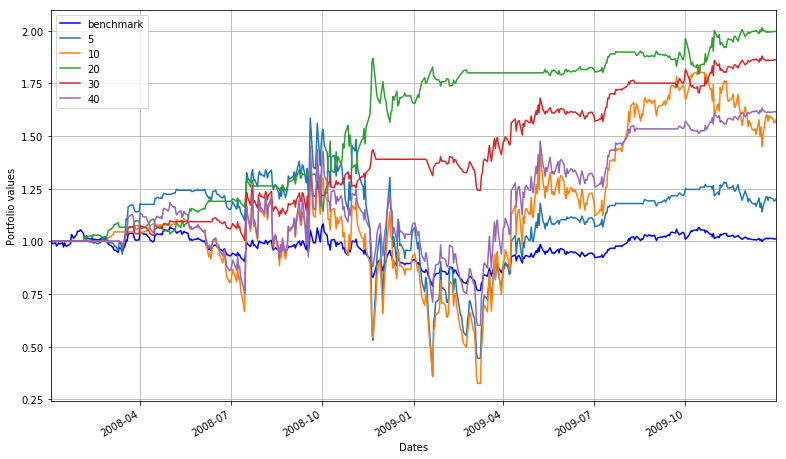

In [41]:
# compare n_days - use the fig to show how important the param value is !!
range_ndays_momentum = [5,10, 20, 30, 40]
momentum_portolios_dataframe = get_portfolios_dataframe(testPolicyMixed, df_prices, range_ndays_momentum)
idc.plot_compare_portfolios(momentum_portolios_dataframe, benchmark)

In [ ]:
# compare tresh_momt - use the fig to show how important the param value is !!
range_tresh_momentum = [0.1, 0.2, 0.3, 0.6, 0.7]
momentum_portolios_dataframe = get_portfolios_dataframe_tresh(testPolicyMixed, df_prices, range_tresh_momentum)
idc.plot_compare_portfolios(momentum_portolios_dataframe, benchmark)

In [ ]:
pd.concat([
    compute_portfolio_stats(benchmark.values, name ='benchmark'),
    compute_portfolio_stats(momentum_portolios_dataframe['0.3'].values, name ='0.3'), 
    compute_portfolio_stats(momentum_portolios_dataframe['0.2'].values, name ='0.2')], axis = 1)

Higher cr, higher sharpe ratios : We use a treshold for momentum equal to 0.2

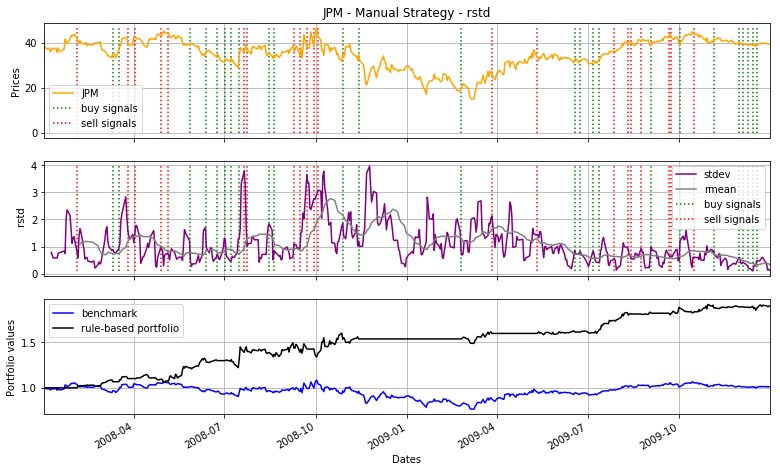

In [82]:
#  20/20/5/0.8/0.2/2/0.0 -> 1.57294
df_trades_mixed, rstd = testPolicyMixed(20,20,5,0.8,0.2,3,0,'JPM', dt.datetime(2008,1,1), dt.datetime(2009, 12, 31))
df_buy_signals_mixed = df_trades_mixed[df_trades_mixed.values == 1000]
df_sell_signals_mixed = df_trades_mixed[df_trades_mixed.values == -1000]
df_portval_mixed = normalize_dataframe(get_portfolio_value(df_prices, df_trades_mixed, symbol))

idc.plot_strategy(df_prices, df_portval_mixed, benchmark, rstd, ' rstd', df_buy_signals_mixed, df_sell_signals_mixed)

In [ ]:
No filter on std, for sell orders
Filter on std for buy orders, smaller cr but reduces risk of the stock : higher sharpe ratio.